# Вступление

Используемая архитектура нейронной сети - это так называемая U-Net, которая используется для сегментации изображений.

Начнем импортировать все, что нам понадобиться в дальнейшем для работы.

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Установим переменные-константы
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.


In [2]:
# Получаем id обучающей и тестовой выборки
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Получаем данные

Импортируем все изображения и связанные с ними маски. Уменьшаем выборки как обучающих, так и тестовых изображений, чтобы они были "легкими в управлении", но при этом необходимо вести учет исходных размеров тестовых изображений, чтобы затем увеличивать наши прогнозируемые маски и позже создать правильные кодировки длин серий.

In [3]:
# Получаем и изменяем размер изображений и их масок для обучения
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Получаем и изменяем размер изображений и их масок для обучения')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                          preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
  Y_train[n] = mask

# Получаем и изменяем размер изображений для тестирования
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Получаем и изменяем размер изображений для тестирования')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = img

print('Выполнена обработка всех изображений!')

Получаем и изменяем размер изображений и их масок для обучения


100%|██████████| 670/670 [07:34<00:00,  1.47it/s]

Получаем и изменяем размер изображений для тестирования



100%|██████████| 65/65 [00:01<00:00, 34.84it/s]

Выполнена обработка всех изображений!


Посмотрим, все ли OK, отрисовав несколько случайных изображений и связанных с ними масками.

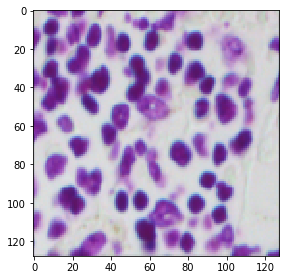

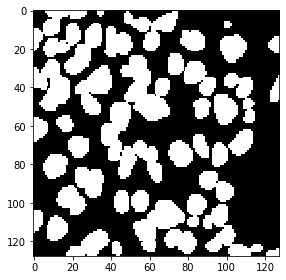

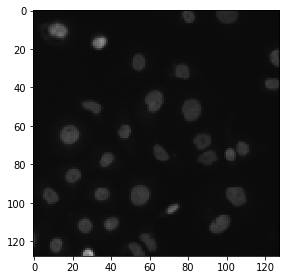

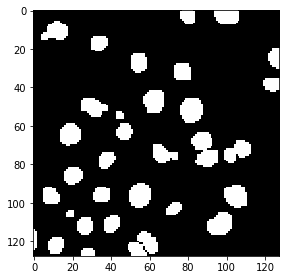

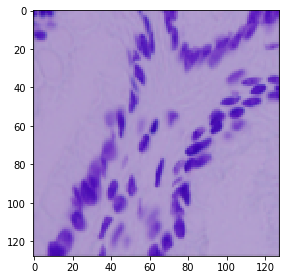

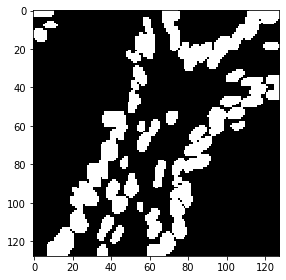

In [4]:
for i in range(3):
  ix = random.randint(0, len(train_ids))
  imshow(X_train[ix])
  plt.show()
  imshow(np.squeeze(Y_train[ix]))
  plt.show()

Выглядит отлично!

# Создание метрики

Теперь мы попытаемся определить среднюю точность в метрике меры Сёренсена в Keras-е. 

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Соберем и обучим НС
Затем мы создаем модель U-Net, основанную на [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf).

![U-Net](https://github.com/dexXxed/UNet-Quantum-Task/blob/master/img/u-net-architecture.png?raw=true)

In [6]:
# Пропишем U-Net модель
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)


c10 = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[c10])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
# Fit-им модель
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,
                    callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 123s 204ms/step - loss: -0.5493 - dice_coef: 0.5503 - val_loss: -0.6091 - val_dice_coef: 0.6298

Epoch 00001: val_loss improved from inf to -0.60906, saving model to model.h5
Epoch 2/50
603/603 [==============================] - 134s 222ms/step - loss: -0.6829 - dice_coef: 0.6828 - val_loss: -0.6367 - val_dice_coef: 0.6535

Epoch 00002: val_loss improved from -0.60906 to -0.63665, saving model to model.h5
Epoch 3/50
603/603 [==============================] - 141s 233ms/step - loss: -0.7060 - dice_coef: 0.7059 - val_loss: -0.6494 - val_dice_coef: 0.6650

Epoch 00003: val_loss improved from -0.63665 to -0.64939, saving model to model.h5
Epoch 4/50
603/603 [==============================] - 133s 220ms/step - loss: -0.7107 - dice_coef: 0.7093 - val_loss: -0.6498 - val_dice_coef: 0.6654

Epoch 00004: val_loss improved from -0.64939 to -0.64985, saving model to model.h5
Epoch 5/50
603/603 [====

# Делаем предсказания
Делаем прогнозы как на тестовой выборке, так и на значениях масок и обучающей выборке (в качестве проверки работоспособности). Не забываем загрузить лучшую сохраненную модель.

In [8]:
# Предсказываем, основываясь на тестовой выборке, так и на значениях масок и обучающей выборке
model = load_model('model.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Отсеиваем прогнозы
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Создайте список тестовых масок с повышенной дискретизацией
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 4s 68ms/step


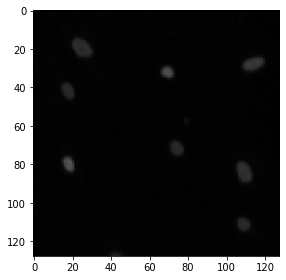

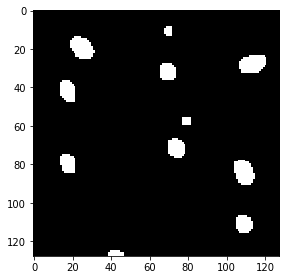

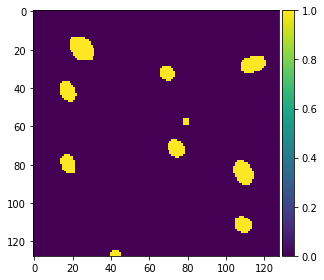

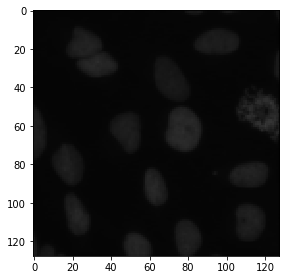

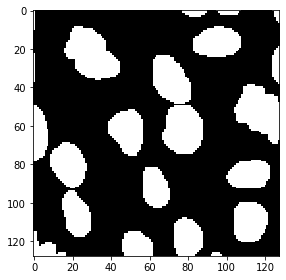

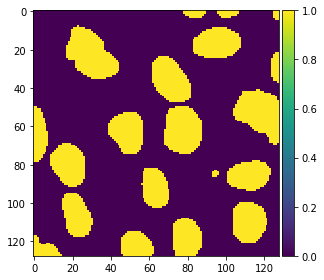

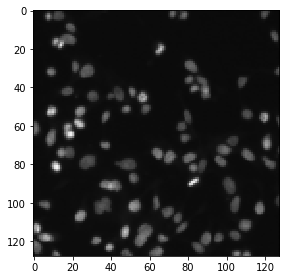

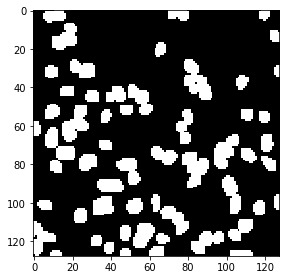

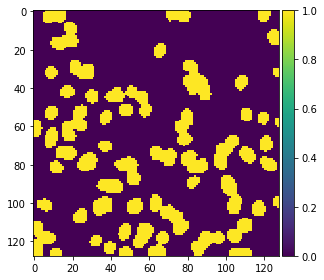

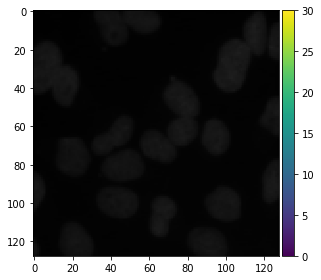

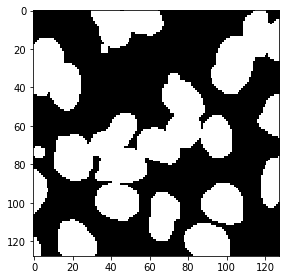

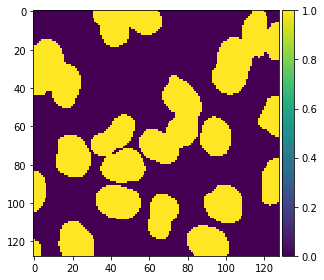

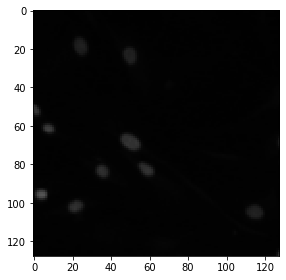

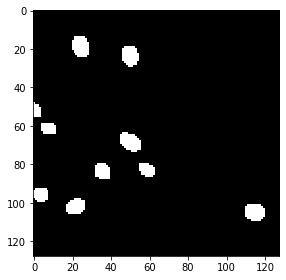

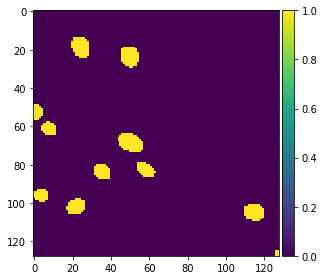

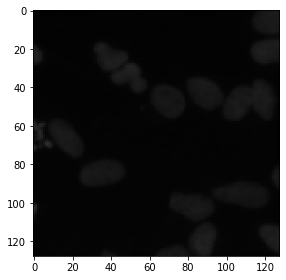

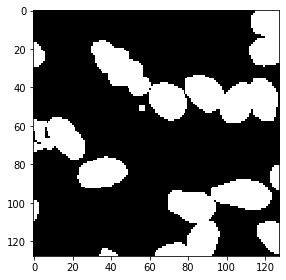

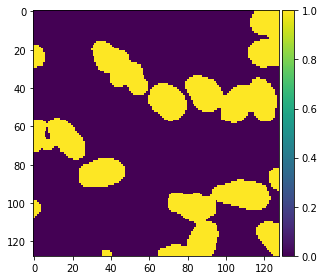

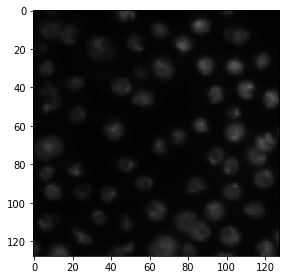

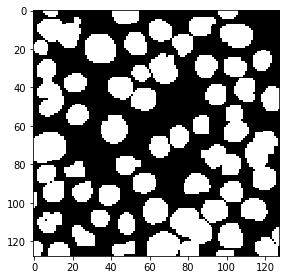

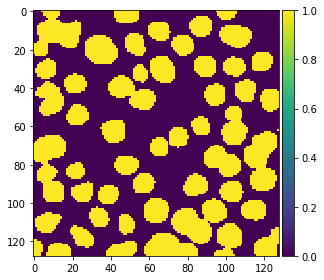

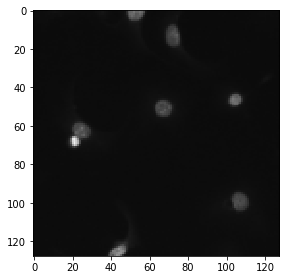

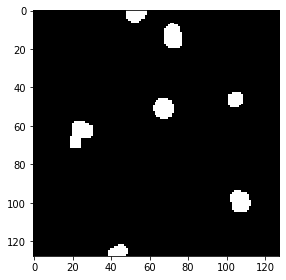

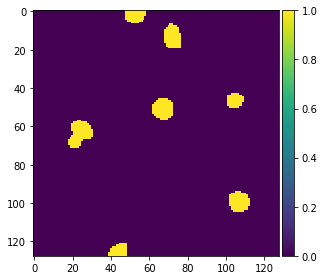

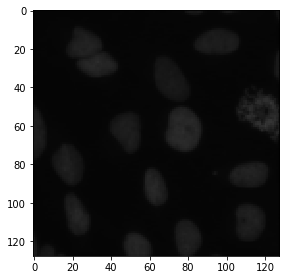

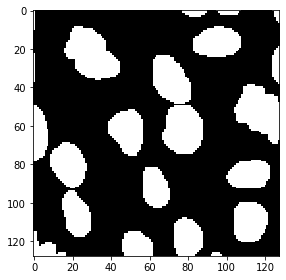

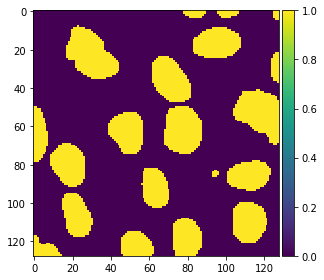

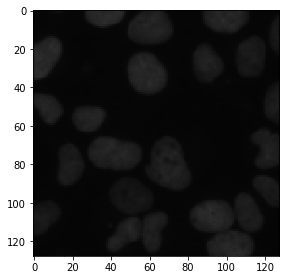

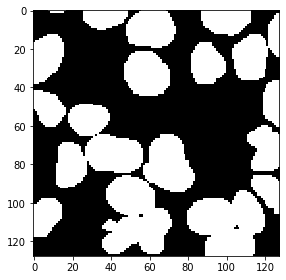

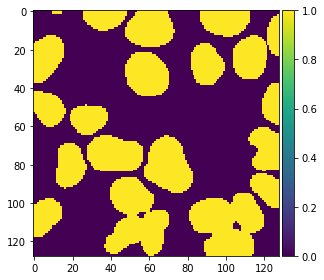

In [9]:
for i in range(10):
    # Выполним проверку работоспособности на некоторых случайных тестовых выборках
    ix = random.randint(0, len(preds_val_t))
    imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
    plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0] * 0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()